In [1]:
## Notebook env: brian_script_env (R kernel)

In [2]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


path2 = '/khayyam/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_her2/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
## load patient metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

[1] FALSE

png 
  2

png 
  2

[1] 73.49141

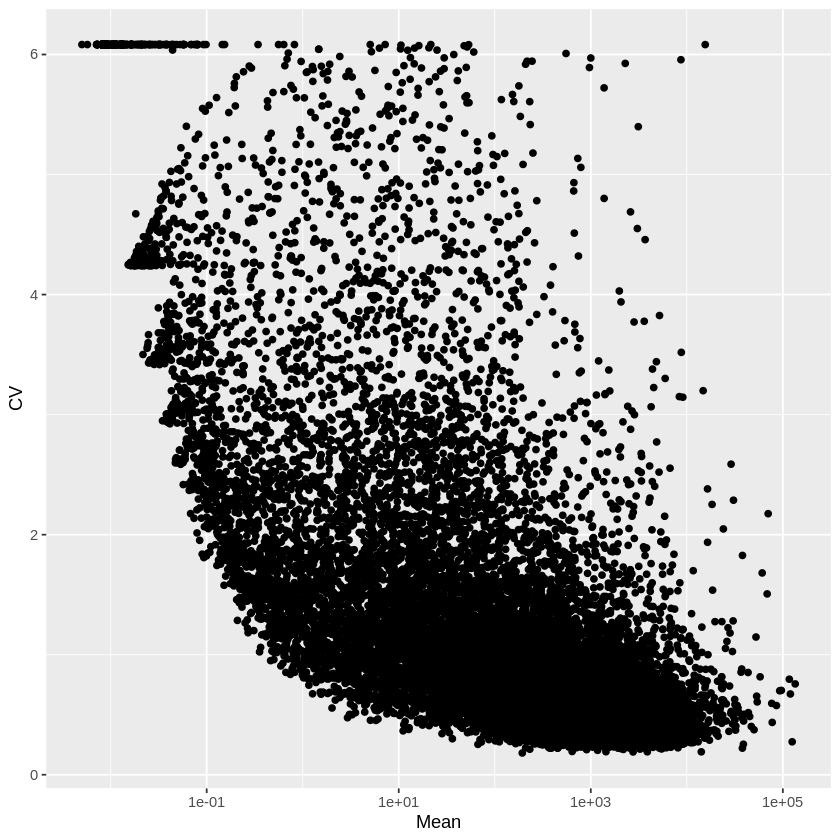

In [4]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_her2$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path2, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path2, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 573

[1] TRUE

[1] TRUE

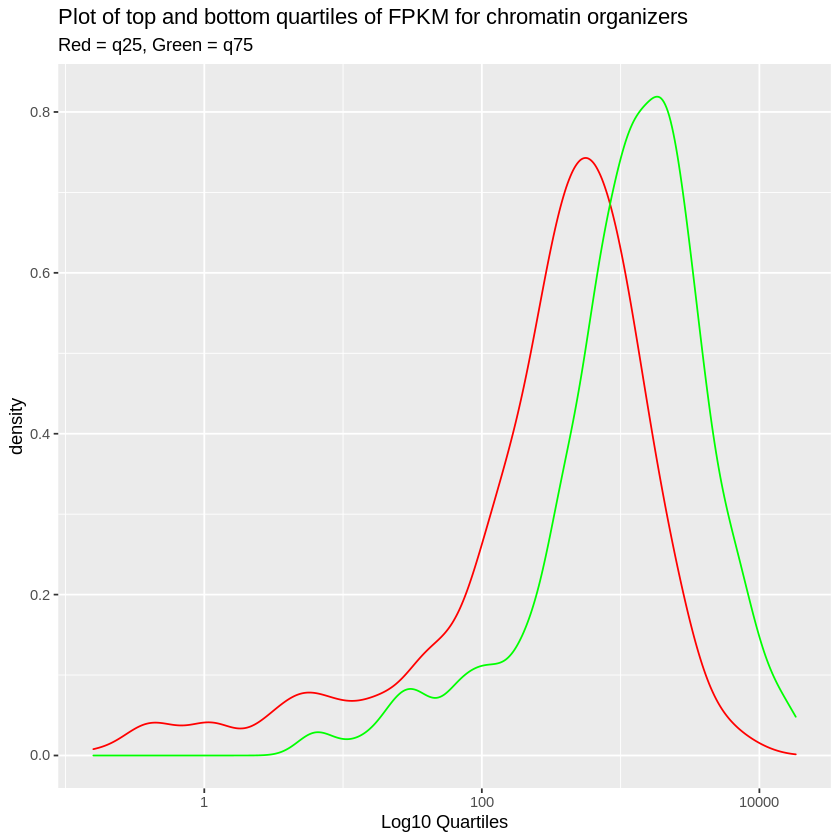

In [5]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.10), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.90), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [6]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path2, 'gped_clean_df_CV_ratio_q10_q90.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:4] "TCGA.A8.A0A7.01" "TCGA.BH.A1EN.01" "TCGA.E2.A1LE.01" "TCGA.LD.A9QF.01"
 $ : chr [1:4] "TCGA.A8.A07R.01" "TCGA.C8.A12Q.01" "TCGA.C8.A1HK.01" "TCGA.C8.A278.01"


Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels <= q25:
“longer object length is not a multiple of shorter object length”
Warning message in col$expression_levels >= q75:
“longer object length is not a multiple of shorter object length”


List of 554
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:4] "TCGA.A2.A04W.01" "TCGA.BH.A1EN.01" "TCGA.E9.A1ND.01" "TCGA.LD.A9QF.01"
  ..$ : chr [1:4] "TCGA.A8.A07R.01" "TCGA.BH.A18T.01" "TCGA.E2.A14P.01" "TCGA.E9.A22G.01"
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:4] "TCGA.BH.A0EE.01" "TCGA.C8.A12Z.01" "TCGA.D8.A1XT.01" "TCGA.E9.A22G.01"
  ..$ : chr [1:4] "TCGA.A2.A0D1.01" "TCGA.AO.A0JE.01" "TCGA.C8.A12Q.01" "TCGA.E2.A14P.01"
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:4] "TCGA.A2.A04W.01" "TCGA.A2.A0D1.01" "TCGA.AO.A0JE.01" "TCGA.C8.A135.01"
  ..$ : chr [1:4] "TCGA.A8.A07R.01" "TCGA.BH.A0EE.01" "TCGA.D8.A1JA.01" "TCGA.UU.A93S.01"
 $ :List of 4
  ..$ : chr "ACTR8"
  ..$ : chr "N"
  ..$ : chr [1:4] "TCGA.AN.A04C.01" "TCGA.C8.A135.01" "TCGA.C8.A137.01" "TCGA.E2.A1LE.01"
  ..$ : chr [1:4] "TCGA.AR.A24U.01" "TCGA.C8.A12P.01" "TCGA.D8.A1JA.01" "TCGA.E2.A1B0.01"
 $ :List of 4
  ..$ : chr "AEBP2"
  ..$ : chr "N"
  ..$ : chr [1:4]

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	19737 obs. of  6 variables:
  ..$ Hugo_Symbol    : chr [1:19737] "UBE2Q2P3" "UBE2Q2P3" "LOC149767" "TIMM23" ...
  ..$ Entrez_Gene_Id : int [1:19737] 100133144 100134869 10357 10431 155060 26823 280660 340602 388795 390284 ...
  ..$ TCGA.A2.A04W.01: num [1:19737] 1.31 4.64 101.33 1759.83 137.78 ...
  ..$ TCGA.BH.A1EN.01: num [1:19737] 4.64 3.3 64.96 1585.47 47.31 ...
  ..$ TCGA.E9.A1ND.01: num [1:19737] 0 4 88.3 897 75 ...
  ..$ TCGA.LD.A9QF.01: num [1:19737] 2.94 4.41 81.32 932.94 287.32 ...
 $ :'data.frame':	19737 obs. of  6 variables:
  ..$ Hugo_Symbol    : chr [1:19737] "UBE2Q2P3" "UBE2Q2P3" "LOC149767" "TIMM23" ...
  ..$ Entrez_Gene_Id : int [1:19737] 100133144 100134869 10357 10431 155060 26823 280660 340602 388795 390284 ...
  ..$ TCGA.A8.A07R.01: num [1:19737] 41.4 18.9 227.7 1578.3 55.2 ...
  ..$ TCGA.BH.A18T.01: num [1:19737] 7.63 19.6 142.88 2273.7 113.13 ...
  ..$ TCGA.E2.A14P.01: num [1:19737] 11.55 2.46 182.47 1208

[1] TRUE

[1] FALSE

[1]  1.062497798  0.726788884  0.493966723  1.467747981  0.640406383
    [6]  0.642520818          NaN          NaN  1.743832243  0.836082648
   [11]  1.193717996  0.514139898          NaN  1.332534521  1.458509565
   [16]  0.593335209  1.069209734  2.449150556          NaN          NaN
   [21]  0.721611861  0.351307358  1.124084389  3.053358704  0.917709785
   [26]  0.913231331  0.929542967  2.079133677  0.633584296  0.732133827
   [31]  0.578124749          NaN  2.607188686          NaN  1.386667355
   [36]  1.000000000          NaN          NaN  1.635217152  0.864239467
   [41]  3.772312314  1.143055487  0.960744174  0.850985362  1.585875909
   [46]  0.152732949  1.581919388  1.116684685  2.448022232  0.921222717
   [51]  0.294126612  1.149107450  2.321892799  1.607064819  0.128285604
   [56]  1.419568913  1.055731611  2.207378772  0.920105077  3.084569443
   [61]  1.352953728  1.337972564  1.581668863  0.923714783  7.127038026
   [66]  1.137498752  1.453079042  0.874476675  2.051023774  0.374166405
   [71]  1.327283695  0.821563085  0.901200781  1.922421332  0.339135447
   [76]  0.848068492  0.704481985  1.122106624  0.925621141  0.988702282
   [81]  0.547637133  0.834928341  1.480650308  0.585412586  0.542617722
   [86]  0.791684389  1.168104984  0.951778012  1.024131413  2.366379985
   [91]  0.697183939  1.981880290  1.599789116  0.992420461  6.863727968
   [96]  3.586414247  2.221808780  0.553068800  2.543662665  2.321653539
  [101]  2.110424566  2.020075353  1.015362240  0.556716172  1.322441950
  [106]  0.818678223  1.025223990  1.118866613  1.484910765  1.995446172
  [111]  0.335545549  1.563344626  1.558251090  2.748888539  1.080583289
  [116]  2.044291804  3.468869759  1.341368160  1.125922796  0.638023222
  [121]  1.816953391  0.919478224  0.467029633  1.320880656  3.121035062
  [126]  2.857138637  0.841420501  0.835324338  1.853548329  0.744639373
  [131]  0.970587403  6.029414726  1.288939370  3.521087317  1.125884643
  [136]  2.462249492  1.004857797  1.118398603  0.740582801  0.694985600
  [141]  0.544510863  0.437516768  0.968911590  0.951297795  1.776754805
  [146]  0.552121826  3.733245984  1.690958949  1.054372447  0.873007442
  [151]  1.220451972  1.536066280  2.465880396  2.308576423  0.998113848
  [156]  0.918272554  0.862168788  0.844787136  0.775197694  5.159760781
  [161]  0.435800589  8.274929663          NaN          NaN  0.931892274
  [166]  0.736833151  1.121081992  3.346179699  1.295872879  0.384457904
  [171]  1.050079095  0.707079826  0.693919743  3.135422467  1.054126535
  [176]  0.633557169  0.463758745  2.037978649  2.402917274          NaN
  [181]  0.725431868  1.449000382  1.098705889  1.526895200  3.208616449
  [186]  0.645192710  0.450048329  1.566527649  1.520842770  2.112662455
  [191]  1.707841590  3.764368717  0.778639654  0.352677555  1.435618742
  [196]  1.128772502  0.643880674  1.370708996          NaN  1.258706901
  [201]  0.892483151  0.453950332  0.971752034  0.644614981  0.544412109
  [206]  0.755008451  0.262599144  1.280807402  2.588782522  0.701623589
  [211]  0.833409088  1.097353380  0.550858468  1.696307164          NaN
  [216]  1.159361719  0.751130119  1.451654467  1.604237022  0.724740259
  [221]  0.705261072  2.005713934  1.672610373  1.661738340  1.428562677
  [226]  1.328249635  1.026939110  1.631290249  0.452677386          NaN
  [231]          NaN          NaN  0.689492881  0.926904977  2.729373197
  [236]  1.310135642  3.741068163  5.508351809  1.395423451  2.673689274
  [241]  2.045732460  1.374886839  0.366183934  1.310250105  2.409813421
  [246]  0.735719546  0.884436311          NaN          NaN  3.979459792
  [251]  0.155899532  3.197233700  0.964748435  1.456328314  2.716133192
  [256]  2.810711533  1.490307194  1.883375980  1.981285581          NaN
  [261]  1.223601705  1.039826650  1.898854735  1.302089767  1.297126821
  [266]  0.805452900  2.345572804          NaN  1.801294262  1.194105947
  [271]  1.565739271  0.779085884  0.949316845  1.180755521  0

[1] TRUE

[1] TRUE